# Notes for user:

*   This notebook will use the dataset COVID-19 (positive cases and death rates) and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? GBP/USD (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to the GBP.
*   Therefore, we look at the death rates & positive cases in the US.
*   We are looking at dates: 31st Dec 2019 - 31st July 2020.
*   LSTMs are good at looking at changed over time. 


# Part 2: LSTM to predict Forex Spot Price

# Imports

In [ ]:
# Imports
!pip install git+https://github.com/tensorflow/docs
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
#plotting
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# metrics
import math
# to create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6e8rjhvx
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6e8rjhvx
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.05c4bd64cc6466af361dfd1f7e19625e7de52fc37_-cp36-none-any.whl size=126759 sha256=8fbc0cd1e11921dff2af9b5395170e22bf1141ad0d35c4a109a114c0c67eec29
  Stored in directory: /tmp/pip-ephem-wheel-cache-sa3az73q/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


In [ ]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Data Collection


In [ ]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()  
# We do not want to drop empty tables as this is null values are part of our dataset
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,0.0,0.0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.0,0.0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-24,12.0,8.0,0.0,0.0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
3,ABW,North America,Aruba,2020-03-25,17.0,5.0,0.0,0.0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
4,ABW,North America,Aruba,2020-03-26,19.0,2.0,0.0,0.0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [ ]:
# Trying to isolate location based on currency in question
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_cases', 'total_deaths']]
us_death_rates.head()

,location,date,total_cases,total_deaths
32403,United States,2019-12-31,0.0,0.0
32404,United States,2020-01-01,0.0,0.0
32405,United States,2020-01-02,0.0,0.0
32406,United States,2020-01-03,0.0,0.0
32407,United States,2020-01-04,0.0,0.0


In [ ]:
# Import forex
forex_dataset_data= pd.read_csv('investing_with_doubles.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()

In [ ]:
# Why are these different?
print(us_death_rates.shape), print(forex_dataset.shape)

(218, 4)
(213, 6)


(None, None)

# Data Preprocessing / Data Cleaning & Collating
*   Eliminating columns we dont want
*   Merging tables based on 'Date' column
*   Dates in question: Dec 31 2019 - Jul 31, 2020
*   Once complete we pop the 'date' we merged on 

In [ ]:
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')

0      -0.04%
1       0.76%
2       0.49%
3       0.38%
4       0.72%
        ...  
208     0.62%
209    -0.44%
210    -0.82%
211    -0.05%
212     1.11%
Name: Change %, Length: 213, dtype: object

In [ ]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_cases,total_deaths
32403,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0
32404,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0
32405,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0
32406,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0
32407,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0


In [ ]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()


,Date,Price
208,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",1.3169
209,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088
210,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146
211,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255
212,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261


In [ ]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()
print(dataset)
len(dataset)

                                    Date   Price  ... total_cases total_deaths
0     (2020, 7, 31, 0, 0, 0, 4, 213, -1)  1.3090  ...   4495014.0     152070.0
1     (2020, 7, 30, 0, 0, 0, 3, 212, -1)  1.3095  ...   4426982.0     150713.0
2     (2020, 7, 29, 0, 0, 0, 2, 211, -1)  1.2996  ...   4351997.0     149256.0
3     (2020, 7, 28, 0, 0, 0, 1, 210, -1)  1.2932  ...   4290263.0     148011.0
4     (2020, 7, 27, 0, 0, 0, 0, 209, -1)  1.2882  ...   4234020.0     146935.0
..                                   ...     ...  ...         ...          ...
208      (2020, 1, 4, 0, 0, 0, 5, 4, -1)  1.3169  ...         0.0          0.0
209      (2020, 1, 3, 0, 0, 0, 4, 3, -1)  1.3088  ...         0.0          0.0
210      (2020, 1, 2, 0, 0, 0, 3, 2, -1)  1.3146  ...         0.0          0.0
211      (2020, 1, 1, 0, 0, 0, 2, 1, -1)  1.3255  ...         0.0          0.0
212  (2019, 12, 31, 0, 0, 0, 1, 365, -1)  1.3261  ...         0.0          0.0

[213 rows x 6 columns]


213

In [ ]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0       (2020, 7, 31, 0, 0, 0, 4, 213, -1)
1       (2020, 7, 30, 0, 0, 0, 3, 212, -1)
2       (2020, 7, 29, 0, 0, 0, 2, 211, -1)
3       (2020, 7, 28, 0, 0, 0, 1, 210, -1)
4       (2020, 7, 27, 0, 0, 0, 0, 209, -1)
                      ...                 
208        (2020, 1, 4, 0, 0, 0, 5, 4, -1)
209        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
210        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
211        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
212    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 213, dtype: object

In [ ]:
dataset.head()

,Date,Price,location,total_cases,total_deaths
0,"(2020, 7, 31, 0, 0, 0, 4, 213, -1)",1.3090,United States,4495014.0,152070.0
1,"(2020, 7, 30, 0, 0, 0, 3, 212, -1)",1.3095,United States,4426982.0,150713.0
2,"(2020, 7, 29, 0, 0, 0, 2, 211, -1)",1.2996,United States,4351997.0,149256.0
3,"(2020, 7, 28, 0, 0, 0, 1, 210, -1)",1.2932,United States,4290263.0,148011.0
4,"(2020, 7, 27, 0, 0, 0, 0, 209, -1)",1.2882,United States,4234020.0,146935.0


# Plotting Features before Normalisation

## Organising date for plotting

In [ ]:
# View what date looks like
# Splitting timestamp and isolating the date
date = dataset['Date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
print(dateFormatting)

                         new_date
0   2019-12-31 00:00:00.000000000
1   2020-01-01 00:06:47.547169811
2   2020-01-02 00:13:35.094339622
3   2020-01-03 00:20:22.641509434
4   2020-01-04 00:27:10.188679245
..                            ...
208 2020-07-26 23:32:49.811320756
209 2020-07-27 23:39:37.358490568
210 2020-07-28 23:46:24.905660380
211 2020-07-29 23:53:12.452830192
212 2020-07-31 00:00:00.000000000

[213 rows x 1 columns]


In [ ]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)

[Timestamp('2019-12-31 00:00:00'), Timestamp('2020-01-01 00:06:47.547169811'), Timestamp('2020-01-02 00:13:35.094339622'), Timestamp('2020-01-03 00:20:22.641509434'), Timestamp('2020-01-04 00:27:10.188679245'), Timestamp('2020-01-05 00:33:57.735849056'), Timestamp('2020-01-06 00:40:45.283018868'), Timestamp('2020-01-07 00:47:32.830188679'), Timestamp('2020-01-08 00:54:20.377358490'), Timestamp('2020-01-09 01:01:07.924528302'), Timestamp('2020-01-10 01:07:55.471698113'), Timestamp('2020-01-11 01:14:43.018867924'), Timestamp('2020-01-12 01:21:30.566037736'), Timestamp('2020-01-13 01:28:18.113207547'), Timestamp('2020-01-14 01:35:05.660377358'), Timestamp('2020-01-15 01:41:53.207547170'), Timestamp('2020-01-16 01:48:40.754716981'), Timestamp('2020-01-17 01:55:28.301886792'), Timestamp('2020-01-18 02:02:15.849056604'), Timestamp('2020-01-19 02:09:03.396226415'), Timestamp('2020-01-20 02:15:50.943396226'), Timestamp('2020-01-21 02:22:38.490566038'), Timestamp('2020-01-22 02:29:26.037735849'

## Plotting Forex Spot Price

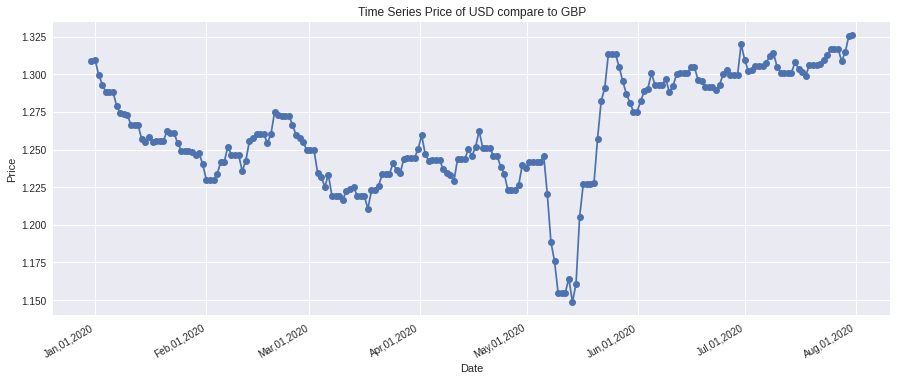

In [ ]:
# Plotted prices and dates
# Notice how the dates start and end

rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

## Plotting Accumulative Covid Deaths

In [ ]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list_arr = np.array(total_us_deaths)
reversed_arr = list_arr[::-1]
newDayDeaths = 0
dayDeaths = []
for currentday in reversed_arr:
   newDayDeaths = currentday + newDayDeaths
   dayDeaths.append(newDayDeaths)


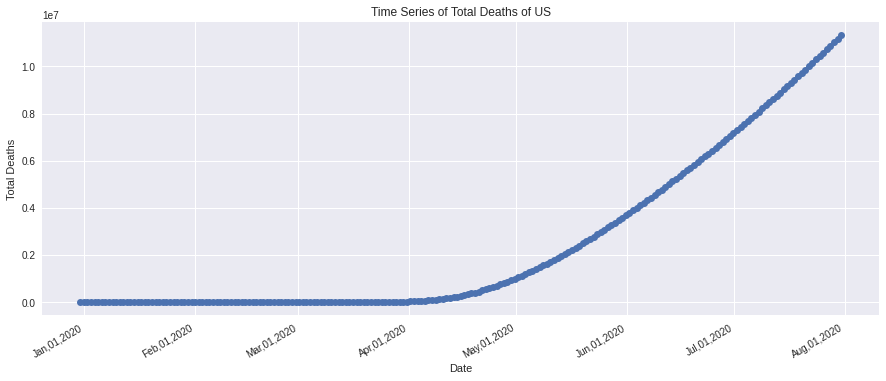

In [ ]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(dayDeaths)
plt.plot_date(dates, us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)



## Plotting Accumulative Positive Cases

In [ ]:
# Adds accumulative positive cases everyday
total_us_cases = dataset['total_cases']
list_arr = np.array(total_us_cases)
reversed_arr = list_arr[::-1]
newDayCases = 0
dayCases = []
for currentday in reversed_arr:
   newDayCases = currentday + newDayCases
   dayCases.append(newDayCases)

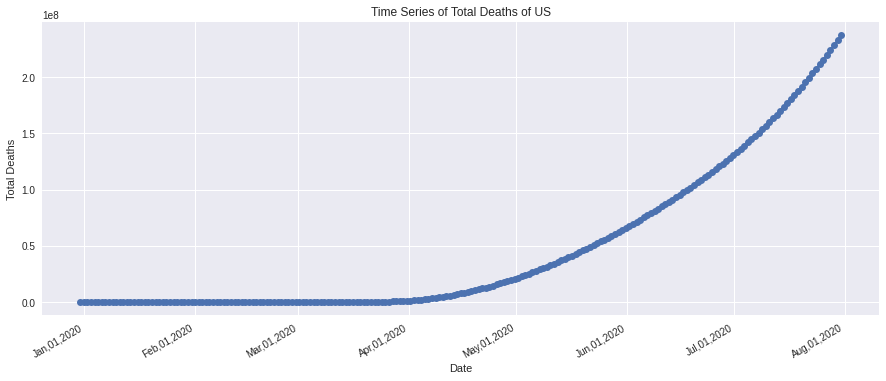

In [ ]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_cases = np.array(dayCases)
plt.plot_date(dates, us_cases, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Features after Normalisation

In [ ]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([dayDeaths]), columns= ["Total_Deaths_US"])
cases_frame = pd.DataFrame(np.concatenate([dayCases]), columns= ["Total_Cases_US"])
# price_frame.append(death_frame)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
normalisation_us_cases = scaler.fit_transform(cases_frame).reshape(-1,1)
# 8 decimal: readable formate:
# val = [print("{:.8f}".format(float(x)))for x in normalisation_us_deaths]

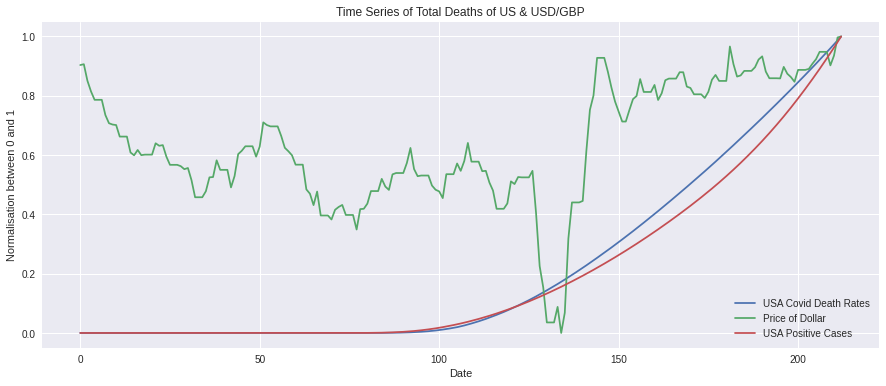

In [ ]:
plt.plot(normalisation_us_deaths,label="USA Covid Death Rates")
plt.plot(normalisation_price, label="Price of Dollar")
plt.plot(normalisation_us_cases, label="USA Positive Cases")

# dates
# dates = np.array(dateFormatting['new_date'])
# plt.plot_date(dates, linestyle ='solid')
# plt.gcf().autofmt_xdate()
# date_format = mpl_dates.DateFormatter('%b,%d,%Y')
# plt.gca().xaxis.set_major_formatter(date_format)

plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()


# Splitting Data into Train, Validation & Test


In [ ]:
# Creating normalised dataset
# Positive Cases | Death Rates | Price of dollar
new_dataset = np.hstack((normalisation_us_cases, normalisation_us_deaths, normalisation_price))

In [ ]:
# Test, Validation, Train 
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 65% of the total length of my datadrame
# 35% validation/test size/ 
training_size = int(len(new_dataset)*0.80)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(170, 3)
(21, 3)
(22, 3)


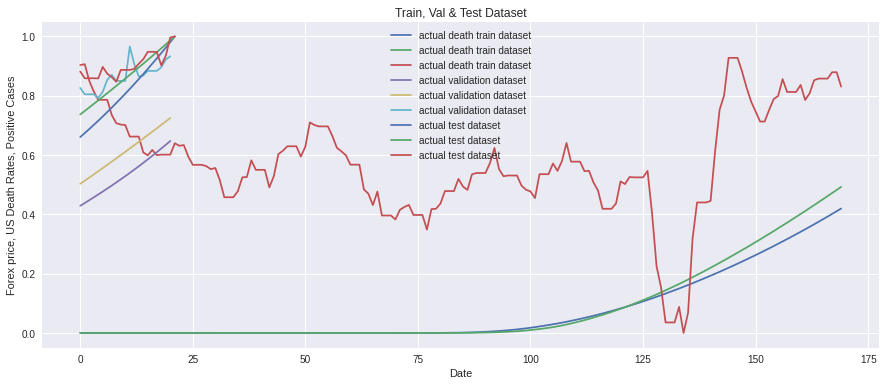

In [ ]:
# Start
plt.plot(train_data, label="actual death train dataset")

# Middle
plt.plot(valset_data, label="actual validation dataset")

# End
plt.plot(test_data, label="actual test dataset")

# as you can see th test data and train is divided because we want to test after a specific day
plt.title('Train, Val & Test Dataset')
plt.ylabel('Forex price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# Looking at first 4 days i.e. index 4 does not count
print(valset_data[:4])

[[0.42888805 0.50305516 0.82638106]
 [0.43824254 0.51356645 0.80496054]
 [0.44774091 0.52413131 0.80496054]
 [0.45734791 0.53471876 0.80496054]]


In [ ]:
print(training_size, test_size)
# why are these different?
print(len(train_data), len(test_data))

170 21
170 22


# X_train, Y_train, X_test, Y_test

In [ ]:
# Convert an array of values into a dataset matrix
# time_step = how many previous days you have to consider before making a prediction. = 1 passing by ref
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # len(dataset) = 154 - 7 = 147 -1 (guarentees 8th datapoint)
  # for i(starting point of dataset), i in range 146
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # from i: until i + 7
    dataX.append(a) # then attach it to dataX
    y = dataset[i + time_step][2]  # attach the feature index 2 which is forex of 3 data predictions to y
    dataY.append(y)
  return np.array(dataX), np.array(dataY)


In [ ]:
# Weekly_timestep means taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)



In [ ]:
print(X_test.shape), print(Y_test.shape)
# Finished preprocessing the data

(14, 7, 3)
(14,)


(None, None)

# Stacked LSTM Model

In [ ]:
# Create the stacked LSTM model

def lstm_model(lr_rate, neuron_layer, optimizer_one):
  # we want input_tensor to be a single data point
  model = Sequential()
  opt = None
  if optimizer_one == 'adam':
   opt = keras.optimizers.Adam(learning_rate=lr_rate)
  elif optimizer_one == 'sgd':
   opt = keras.optimizers.SGD(learning_rate=lr_rate)
  else:
   opt = keras.optimizers.Adamax(learning_rate=lr_rate)
  model.add(InputLayer(input_shape=(7,3)))
  # model.add(LSTM(neuron_layer,return_sequences=True))
  model.add(LSTM(neuron_layer, return_sequences=True))
  model.add(Dense(10))
  model.add(LSTM(neuron_layer))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer=opt)
  return model

  

## Hyperparameter Tuning


*   Optimizers:
[Overview of different Optimizers for neural networks](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3#:~:text=Adagrad%20eliminates%20the%20need%20to,is%20no%20longer%20able%20learning.)
*   [Conceptual Guide for HP Tuning](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35)
*   [Consider this for Grid Search & Random Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
*   [And this](https://stackoverflow.com/questions/58137140/randomizedsearchcv-with-keras-lstm-regression)
![Grid Search & Random Search](https://miro.medium.com/max/1200/1*ZTlQm_WRcrNqL-nLnx6GJA.png)



In [ ]:
# Function to create the best model for hyperparameters method
def bestModel(least_loss, learning_rate_list, optimizer_list, neuron_list):
  for each_neuron in neuron_list:
    for each_optimizer in optimizer_list:
      for each_learning_rate in learning_rate_list:
        our_model = lstm_model(each_learning_rate, each_neuron, each_optimizer)
        our_model.fit(X_train, Y_train, 
                validation_data= 
                (X_val, Y_val)
                , epochs=100,batch_size=10,verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
        loss = our_model.evaluate(X_test, Y_test)
        if loss < least_loss:
          least_loss = loss
          best_learning_rate = each_learning_rate
          best_optimizer = each_optimizer
          best_neuron = each_neuron
    return least_loss, best_learning_rate, best_optimizer, best_neuron

## Grid Search

*   We must choose candidates for good hidden layers and optimizers. Then plot a comparison.
*   List of optimizers: 
*   optimizers = ['SGD', 'RMSprop','adam','adagrad', 'adadelta', 'adamax','nadam', 'ftrl']
*   Callbacks: Restores best weights that is going to give u best model 
*   Consider changing batch size: slower the batch_size better training, because small dataset




In [ ]:
neuron_list = [15,30,10]
optimizer_list = ['adam', 'adamax']
learning_rate_list = [3e-3,3e-4]
least_loss_grid_search = 1

best_grid_search_model = bestModel(least_loss_grid_search, learning_rate_list, optimizer_list, neuron_list)
print(best_grid_search_model)


Epoch 1/100
17/17 [==============================] - 1s 72ms/step - loss: 0.1111 - val_loss: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0209 - val_loss: 0.0058
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0162 - val_loss: 0.0034
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1/100
17/17 [==============================] - 1s 67ms/step - loss: 0.4147 - val_loss: 0.7910
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 0.3300 - val_loss: 0.6453
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 0.2595 - val_loss: 0.5057
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 0.1925 - val_loss: 0.3634
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 0.1249 - val_loss: 0.2184
Epoch 6/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0637 - val_loss: 0.0905
Epoch 7/100
17/17 [====

## Random Search


*   Why do we get different values here then we do for grid search? Shouldnt they be the same?



In [ ]:
# Shuffle hidden_layer list
from random import seed
from random import shuffle


In [ ]:
# Shuffling neuron layers

neuron_list = [15,30,10]
# Seed random number generator
seed(len(neuron_list))
# Prepare a sequence
neuron_sequence = neuron_list
print(neuron_sequence) # Before Shuffle
# Randomly shuffle the sequence hidden layers
shuffle(neuron_sequence) 
print(neuron_sequence) # After Shuffle

# Shuffling optimizers

optimizer_list = ['adam', 'adamax']
# Seed random number generator
seed(len(neuron_sequence))
# Prepare a sequence
op_sequence = optimizer_list
print(op_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(op_sequence)
print(op_sequence) # After Shuffle

# Shuffling learning rate

learning_rate_list = [3e-3,3e-4]
# Seed random number generator
seed(len(neuron_sequence))
# Prepare a sequence
lr_sequence = learning_rate_list
print(lr_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(lr_sequence)
print(lr_sequence) # After Shuffle

# Assigning least_loss
least_loss_random_search = 1
best_random_grid_model = bestModel(least_loss_random_search, lr_sequence, op_sequence, neuron_sequence)
print(best_random_grid_model)

# random search = (0.0006903847679495811, 0.003, 'adam', 30)

[15, 30, 10]
[30, 10, 15]
['adam', 'adamax']
['adamax', 'adam']
[0.003, 0.0003]
[0.0003, 0.003]
Epoch 1/100
17/17 [==============================] - 1s 62ms/step - loss: 0.3114 - val_loss: 0.6434
Epoch 2/100
17/17 [==============================] - 0s 12ms/step - loss: 0.2217 - val_loss: 0.4820
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 0.1465 - val_loss: 0.3315
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0824 - val_loss: 0.1922
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0382 - val_loss: 0.0956
Epoch 6/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0207 - val_loss: 0.0461
Epoch 7/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0181 - val_loss: 0.0347
Epoch 8/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0179 - val_loss: 0.0326
Epoch 9/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0175 - val_loss: 0.0274
Epoc

In [ ]:
# We want the smallest loss
# Therefore if random_search least loss is greater than grid search, make grid search best model the best model.
# 0 = least loss, 1 = learning rate, 2 = optimizer, 3 = neurons
if best_grid_search_model[0] > best_random_grid_model[0]:
  best_learning_rate = best_random_grid_model[1]
  best_optimizer = best_random_grid_model[2]
  best_neuron = best_random_grid_model[3]
else:
  best_learning_rate = best_grid_search_model[1]
  best_optimizer = best_grid_search_model[2]
  best_neuron = best_grid_search_model[3]
print(best_learning_rate)
print(best_optimizer)
print(best_neuron)

# Best Model Prediction

In [458]:
best_param_model = lstm_model(best_learning_rate, best_neuron, best_optimizer)
best_param_model.fit(X_train, Y_train, epochs=150,batch_size=10,verbose=1)
loss = best_param_model.evaluate(X_test, Y_test) 

Epoch 1/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0919
Epoch 2/150
17/17 [==============================] - 0s 8ms/step - loss: 0.0207
Epoch 3/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 4/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0141
Epoch 5/150
17/17 [==============================] - 0s 8ms/step - loss: 0.0138
Epoch 6/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0138
Epoch 7/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 8/150
17/17 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 9/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 10/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 11/150
17/17 [==============================] - 0s 8ms/step - loss: 0.0112
Epoch 12/150
17/17 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 13/150
17/17 [=================

# Using best model to predict on X_train & X_test

In [459]:
# Prediction and check performance metric
train_predict = best_param_model.predict(X_train)
test_predict = best_param_model.predict(X_test)
print(train_predict.shape)
print(test_predict.shape)

(162, 1)
(14, 1)


In [ ]:
# Make sure in same normal
# print(train_predict,Y_train)
# test_predict has too large values - work on hyperparas
# print(test_predict, Y_test)


In [461]:
# print(train_predict,test_predict)

# Performance Metric

*   How well is model performing? A measure of what i am predicting and what should have been predicting.
*  **Mean Absolute Error**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. 
*   **Mean Squared Error**: Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
*   **Kullback-Leibler divergence**, which is also called relative entropy, is a measure of the difference between two probability distributions P and Q where P is the distribution of the observation that we want to see how much it differs from the average prior distribution Q. In statistics, an approximate entropy (ApEn) is a technique used to quantify the amount of regularity and the unpredictability of fluctuations over time-series data.[1]
* [MAE Versus RMSE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)





In [462]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(Y_train, train_predict))
print(mean_absolute_error(Y_test, test_predict))

0.034079233506110654
0.18105341762635538


In [463]:
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(Y_train, train_predict)))
print(math.sqrt(mean_squared_error(Y_test, test_predict)))

0.04619898148065661
0.18235223992877095


In [464]:
# Problem: Y_train, train_predict need to be normalised in order to produce a non negative value?
# Confused on when to normalise and not normalise as I had to transform back for MAE & MSE
# KL Divergence: Probability distribution rather than time series
# Consider this for evaluation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence
# Kl divergence measures difference between 2 probability distributions
# Implementing KL from scratch

def kl_divergence(P,Q):
 epsilon = 0.00001      # Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0.
 P = P+epsilon          #  Made copies to avoid changing the np arrays.
 Q = Q+epsilon
 divergence = np.sum(P*np.log(P/Q))
 return divergence

print(kl_divergence(Y_train, train_predict)) 
print(kl_divergence(Y_test, test_predict))   # Values should be normalized though and they are not currently normalised.


1335.4392701854904
-32.16781495811515


In [465]:
# Implementing KL using scipy.stats
from scipy.stats import entropy
print("\nIndividual Entropy\n")
print(entropy(Y_train))
print(entropy(train_predict))
Y_train_kl = Y_train.reshape(162, 1) # Needed to shape if I wanted to do entropy(_, _)
print("\nPairwise Kullback Leibler divergence\n")
print(entropy(Y_train_kl, qk=train_predict))


Individual Entropy

5.0289937798554565
[5.036936]

Pairwise Kullback Leibler divergence

[0.0049791]


In [466]:
# Converted train_predict from a numpy array to a normal array
print(Y_train) 
train_predict_array = []
for i in train_predict:
  train_predict_array.append(i[0])


[0.73506201 0.70744081 0.70293123 0.70124014 0.66234498 0.66234498
 0.66234498 0.60879369 0.59921082 0.61724915 0.59977452 0.60146561
 0.60146561 0.60146561 0.63979707 0.6313416  0.63359639 0.59470124
 0.56708005 0.56708005 0.56708005 0.56257046 0.5524239  0.55636979
 0.51521984 0.45772266 0.45772266 0.45772266 0.47801578 0.52480271
 0.5259301  0.58229989 0.55016911 0.55016911 0.55016911 0.49098083
 0.52931229 0.60315671 0.61443067 0.62965051 0.62965051 0.62965051
 0.59470124 0.62852311 0.7102593  0.70124014 0.69673055 0.69673055
 0.69673055 0.66403608 0.62457723 0.61273957 0.59921082 0.56764374
 0.56764374 0.56764374 0.48421646 0.46956032 0.43122886 0.47688839
 0.39627959 0.39627959 0.39627959 0.38275085 0.41544532 0.42502818
 0.43179256 0.39797069 0.39797069 0.39797069 0.34892897 0.41770011
 0.41882751 0.43630214 0.47857948 0.47857948 0.47857948 0.51972943
 0.49379932 0.48252537 0.53494927 0.53945885 0.53945885 0.53945885
 0.57328072 0.62401353 0.5529876  0.52874859 0.53100338 0.5310

In [467]:
from scipy.special import rel_entr
# measures the distance by two distributions
# look up expected inputs, check data and print above etc..
p = Y_train
q = train_predict_array
KL_PQ = rel_entr(p,q)
KL_QP = rel_entr(q,p)
print("KL(P||Q): %.3f" % sum(KL_PQ))
print("KL(Q||P): %.3f" % sum(KL_QP)) # inifinity?


KL(P||Q): -3.058
KL(Q||P): inf


# Actual Data, Train Prediction & Test Prediction data

In [468]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict =scaler.inverse_transform(test_predict)


(213, 3)
(213, 3)


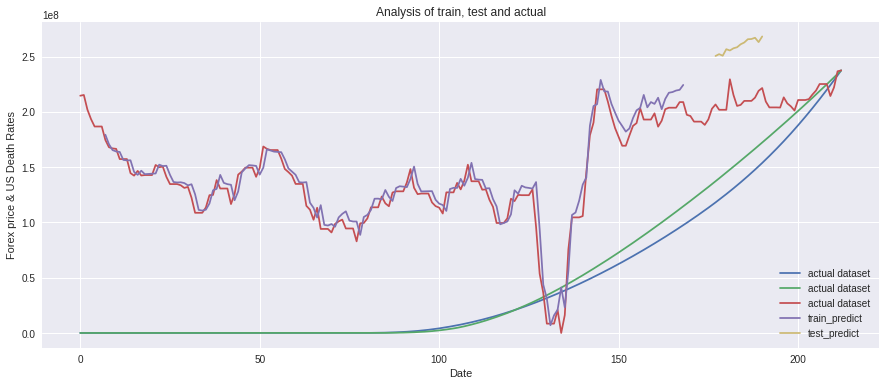

In [469]:
# Problem: testPredictPlot[len(train_predict)+(look_back*2)+2: (training_size + test_size)] = test_predict
# What does this do eactly other than populate the train predict

# Taking in the 7 

look_back = 7

# empty_like: Return a new array with the same shape and type as a given array.
# np.nan: Make all 0 values
# Populates
# What does this do?? 7: predict.length() + 7, :
# 7 until 162 + 7 = 169

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# What does this do exactly? Is there an easier way to implement? predict.length() + (7*2) +1 :(training_size + test_size)] = test_predict

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: (training_size + test_size)] = test_predict
# new_dataset[training_size:(training_size + test_size)]
print(testPredictPlot.shape)

# Plot baseline and predictions
plt.title('Analysis of train, test and actual')
plt.plot(scaler.inverse_transform(new_dataset), label="actual dataset")

trainPredictPlot = [item[2] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")

testPredictPlot = [item[2] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

# as you can see th test data and train is divided because we want to test after a specific day
plt.ylabel('Forex price & US Death Rates')
plt.xlabel('Date')
plt.legend()
plt.show()
# Printing 2 actual_dataset, train_predict, test_predict because 2 input layers

# Custom 21 day prediction (21 is the length of our validation dataset)

*   Training train data to predict future days and evaluating the accuracy on validation data.
*   Training train data to predict future days, no way of evaluating however this can tell us what is likely to occur.
*   Using last 7 days of training data to predict the future custom days(21). 



In [ ]:
# train_data

In [471]:
# Taking the last 7 days of test
# print(test_data[80:])
# is this supposed to be test or train_data
X_input=test_data[100:].reshape(1,-1)
print(X_input)
X_input.shape
temp_input = train_data[-7:] # start, end 
temp_input



[]


array([[0.36645202, 0.43112686, 0.85231116],
       [0.37508216, 0.44124607, 0.85794814],
       [0.38381989, 0.45143297, 0.85794814],
       [0.39263992, 0.46164599, 0.85794814],
       [0.40154401, 0.47189386, 0.87936866],
       [0.41054795, 0.48221551, 0.87936866],
       [0.41965953, 0.4926037 , 0.83089064]])

In [472]:
print(len(valset_data))

21


In [473]:
# Demonstrate prediction for the next 4 days:

# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.

from numpy import array
custom_day = len(valset_data)
lst_output=[]
n_steps=7
i=0
X_input = temp_input
# print(X_input)
while(i<custom_day):
  if(len(temp_input)>7):
    # print(temp_input)  
    X_input=array(temp_input[1:])
    # print("{} day input {}".format(i,X_input))
    # Correct input shape (1,7,3)
    X_input=X_input.reshape((1,n_steps,3))
    # Prediction of X_input
    # print(X_input)
    Y_hat = best_param_model.predict(X_input)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,3))
    Y_hat = best_param_model.predict(X_input, verbose=0)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
# [0.039997526, 0.035484765, 0.029113937, 0.025276443]
# Print the predicted forex price for the next 4 days 
print(lst_output)

[0.9133772, 1.1526415, 1.327025, 1.1522337, 1.1302184, 1.129124, 1.0503732, 1.1836549, 1.3117251, 1.2618577, 1.2538222, 1.2385023, 1.1787025, 1.2234907, 1.2697681, 1.2671055, 1.2716652, 1.2616912, 1.2417729, 1.2503811, 1.2612822]


### Plotting evaluation: Training Prediction of 21 days Versus 21 days of Validation Data.

Predicted validation:
[0.9133772 1.1526417 1.3270255 1.1522343 1.1302186 1.1291243 1.0503732
 1.1836554 1.3117259 1.2618583 1.2538227 1.2385026 1.1787027 1.2234911
 1.2697688 1.267106  1.2716658 1.2616918 1.2417735 1.2503816 1.2612828]
Actual validation:
[0.8263810597519718, 0.8049605411499439, 0.8049605411499439, 0.8049605411499439, 0.7925591882750833, 0.813416009019166, 0.854002254791431, 0.8703494926719273, 0.8500563697857952, 0.8500563697857952, 0.8500563697857952, 0.9661781285231115, 0.9064261555806086, 0.8647125140924459, 0.8686583990980825, 0.8838782412626829, 0.8838782412626829, 0.8838782412626829, 0.8962795941375425, 0.922209695603156, 0.9329199549041709]


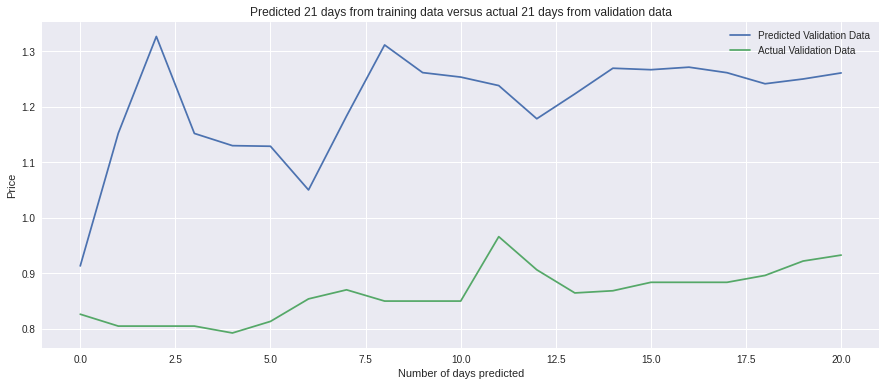

In [ ]:
# Custom day plotted
day_new = custom_day-1

# Predicted 21 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print("Predicted validation:")
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted Validation Data")
# plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
val_data = [item[2] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
print("Actual validation:")
print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual Validation Data")
# plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted 21 days from training data versus actual 21 days from validation data')
plt.xlabel('Number of days predicted')
plt.ylabel('Price')
plt.legend()
plt.show()


# Plotting Prediction of Train, Val 21 days and Test 

In [ ]:
# Problem: Combine both on a graph
# Why validation prediction not on graph?

look_back = 7

# Populate trainPredict
trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# Populate testPredict
testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: (training_size + test_size)] = test_predict
# new_dataset[training_size:(training_size + test_size)]
print(testPredictPlot.shape)

# Plot train data
trainPredictPlot = [item[2] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")

#Plot test data
testPredictPlot = [item[2] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

# Plot predicted validation set from up above
# only one not working?
custom_day_prediction = np.array(lst_output)
plt.plot(custom_day_prediction, label="Predicted Validation Data")

# as you can see th test data and train is divided because we want to test after a specific day
plt.title('Analysis of train prediction, validation prediction based on train data, and test prediction.')
plt.ylabel('Forex price & US Death Rates')
plt.xlabel('Date')
plt.legend()
plt.show()



# Plotting Predicted Train, Test, Validation on Graph as well as Actual Dataset

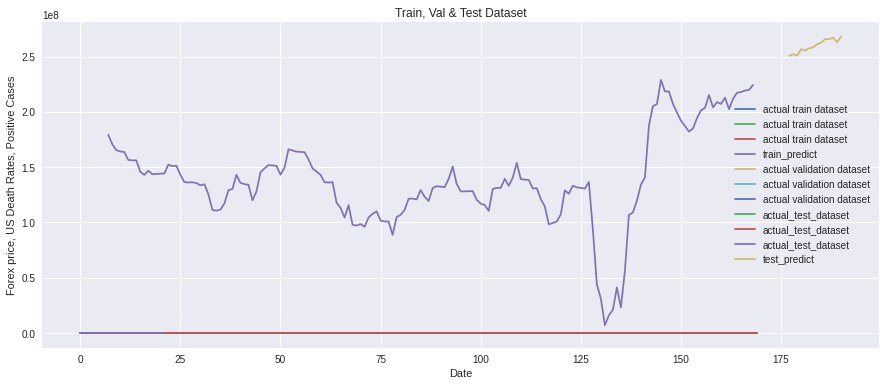

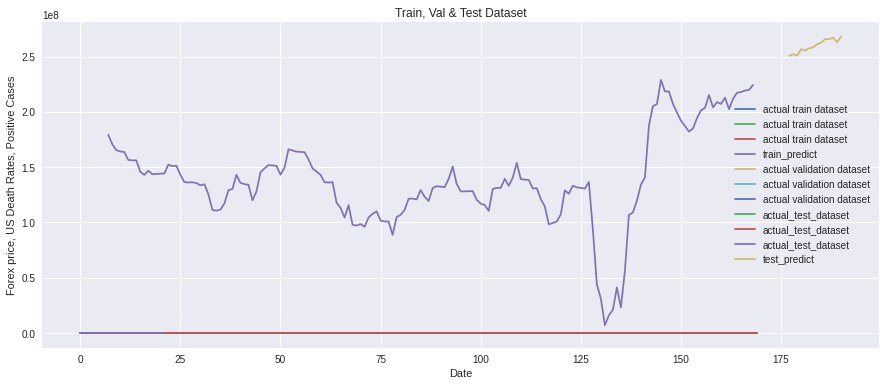

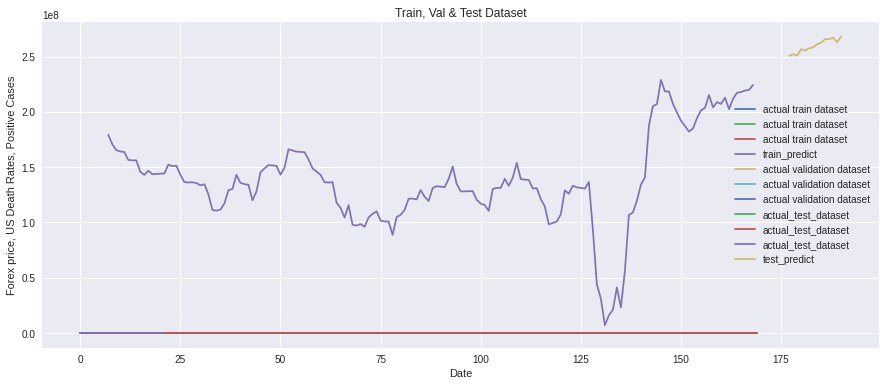

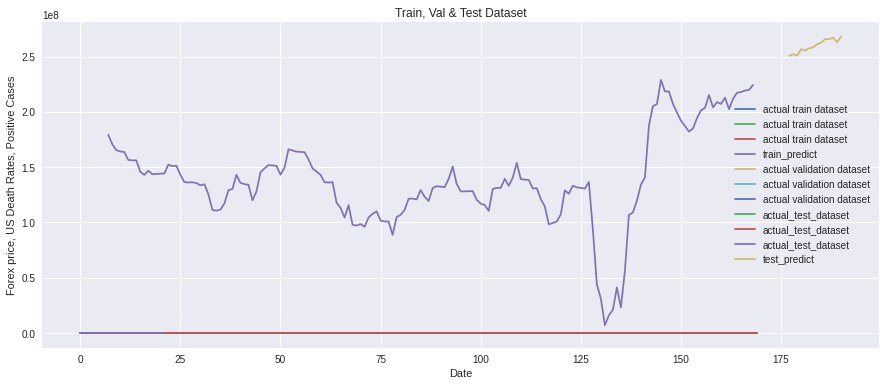

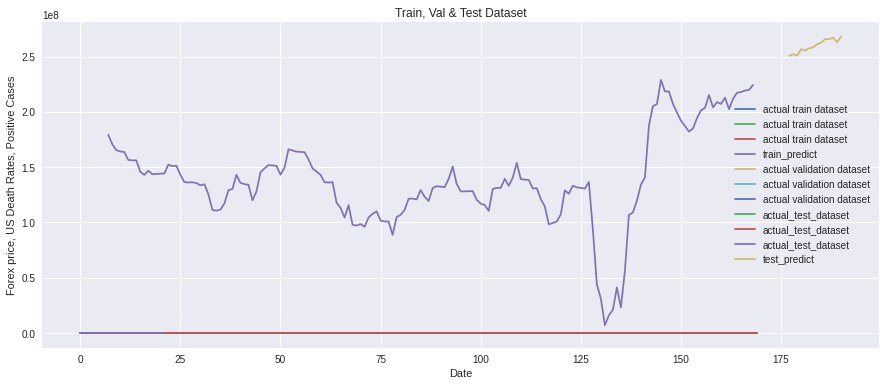

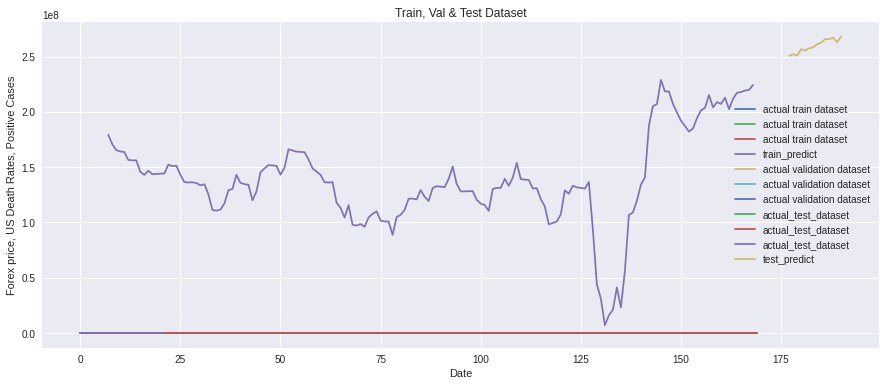

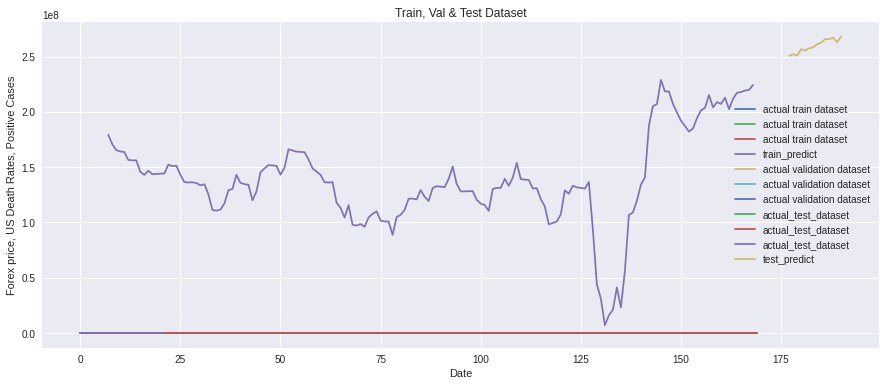

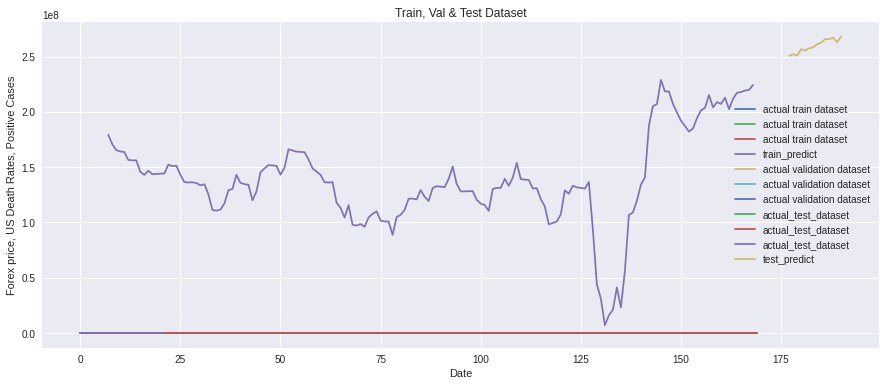

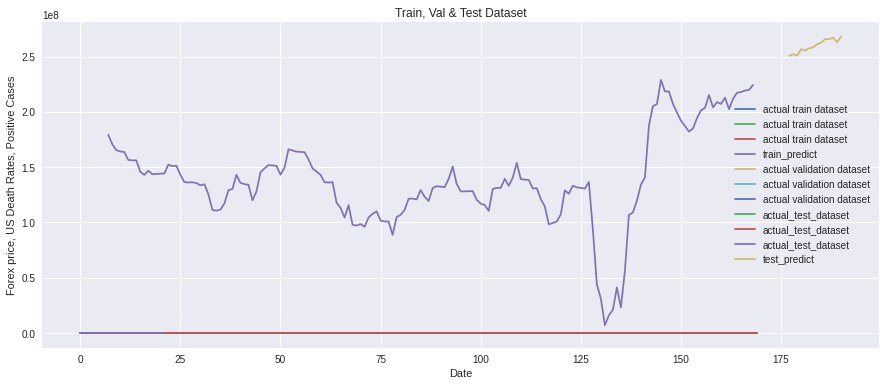

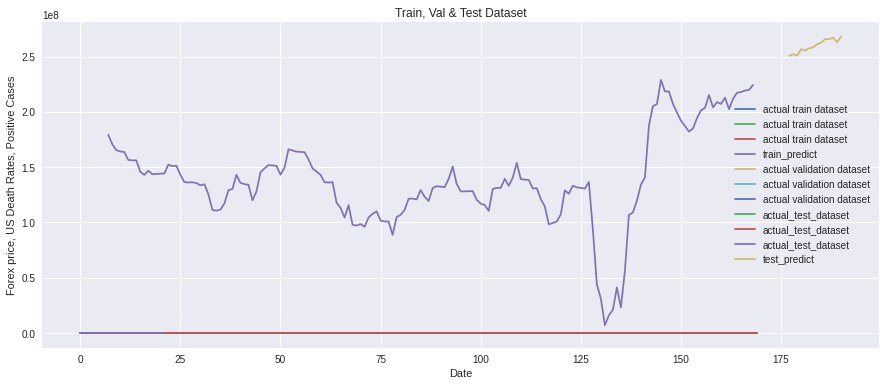

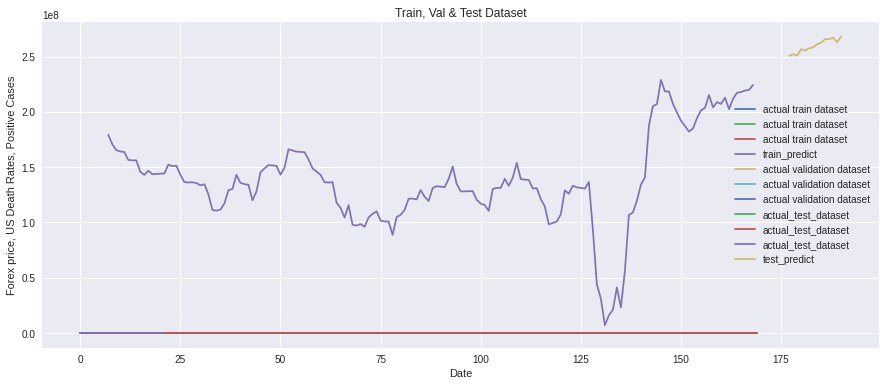

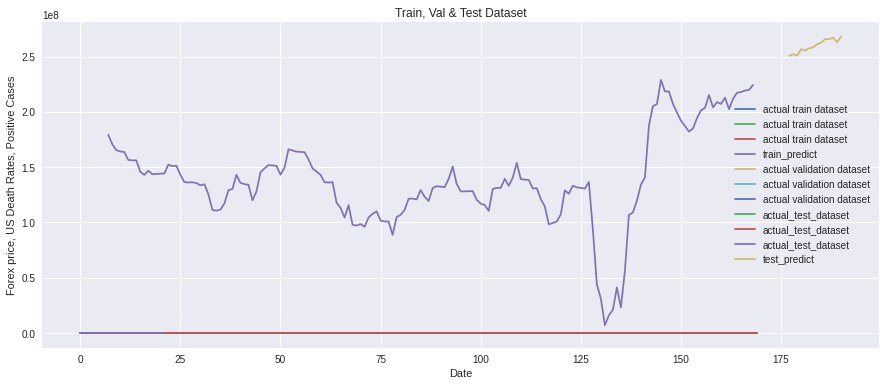

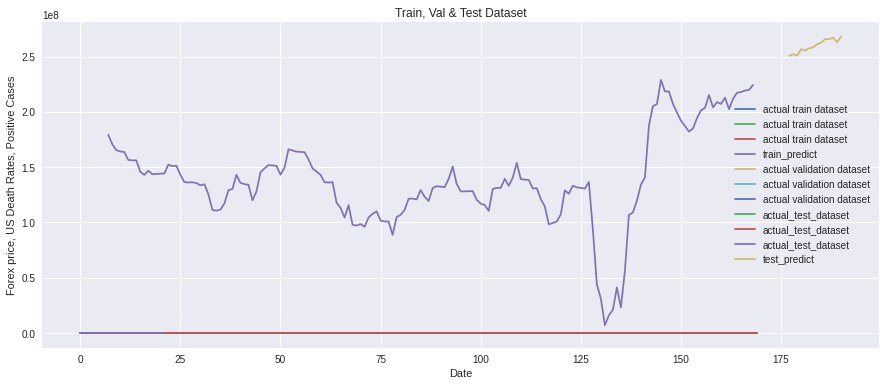

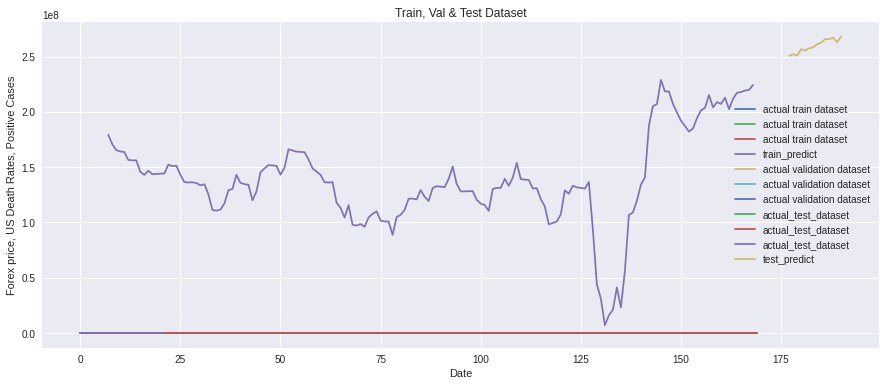

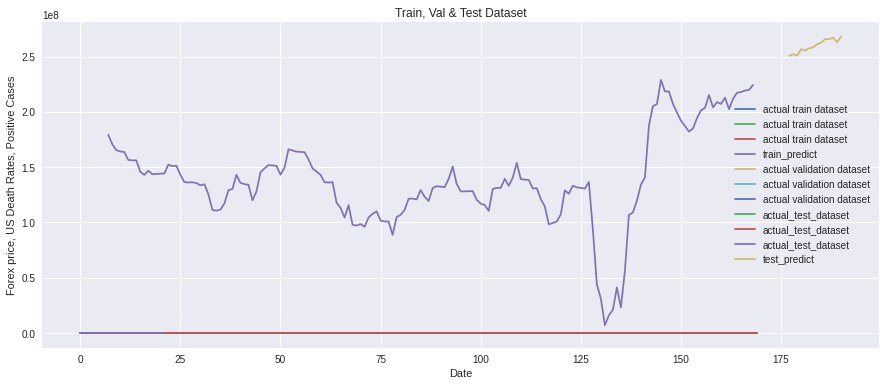

In [476]:
# All of the above + actual data
# Problem why is this not printing out right?
# How can I make my legends tidier?

# Start
plt.plot(train_data, label="actual train dataset")
# Predicted Train
trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
trainPredictPlot = [item[2] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")

# Middle
plt.plot(valset_data, label="actual validation dataset")
# insert predicted val

# End
plt.plot(test_data, label="actual_test_dataset")
# Predicted
testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: (training_size + test_size)] = test_predict
testPredictPlot = [item[2] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")
# insert predict test

# as you can see th test data and train is divided because we want to test after a specific day
plt.title('Train, Val & Test Dataset')
plt.ylabel('Forex price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

# Conclusion and next steps

After exploring the LSTM algorithm:
*   Notes on working with LSTM & Small Dataset
*   Notes on overfitting

In conclusion it seems that ..